# [실습] 조건부 엣지와 툴 노드 연결하기  

이번 실습에서는 모델의 분기점을 구성하는 조건부 엣지와 외부 툴을 효과적으로 사용하는 툴 노드를 추가해 보겠습니다.

In [ ]:
!pip install --upgrade langgraph langchain langchain_google_genai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 792.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.5
    Uninstalling langchain-text-splitters-0.3.5:
      Successfully uninstalled langchain-text-splitters-0.3.5
  Attempting uninstall: langchain
    F

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    rate_limiter=rate_limiter
)

<ipython-input-2-4e191f275e11>:9: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


## 1. 조건부 엣지

조건부 엣지는 워크플로우의 분기점에 해당합니다.   
조건을 구성하여 종료 조건을 만들거나, 조건에 따라 다른 노드로 진입하도록 구성할 수 있습니다.

이번 실습에서는 멀티 턴의 대화를 구현해 보겠습니다.   
질문이 주어지면, 여러 번의 대화를 통해 맥락이 이어집니다.

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

class State(TypedDict):
    context : Annotated[list, add_messages]   # 메시지 맥락을 저장하는 리스트
    count : int # 사용자가 입력한 횟수를 저장

In [ ]:
def ask_human(state):
    query = input()
    print('User :', query)

    return {'context':HumanMessage(content=query)}

def talk(state):
    messages = state['context']

    answer = llm.invoke(messages)

    print('AI :', answer.content)
    state['count'] +=1

    return {'context': answer, 'count': state['count']}


def check_end(state):

    return "Done" if state['count'] >= 3 else "Resume"
    # count가 3 이상이 되면 True, 이외 False






In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node('talk', talk)
builder.add_node('ask_human', ask_human)

builder.add_edge(START, 'ask_human'),
builder.add_edge('ask_human', 'talk'),

builder.add_conditional_edges('talk', check_end,
                              {'Done': END, 'Resume': 'ask_human'})


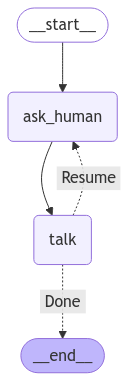

In [ ]:
graph = builder.compile()
graph

In [ ]:
system_prompt = '''한 문장 길이로만 대화하세요.'''

messages = [SystemMessage(content=system_prompt)]


response = graph.invoke({'context':messages, 'count':0})
response

안녕하세요, 저는 변형호라고 합니다. 랭그래프가 무엇인가요?
User : 안녕하세요, 저는 변형호라고 합니다. 랭그래프가 무엇인가요?
AI : LangGraph는 LLM 애플리케이션 구축을 위한 라이브러리로, LLM과 도구를 노드로 연결하여 상태를 관리하는 순환 그래프를 만들 수 있습니다.
순환 그래프만 만들 수 있나요?
User : 순환 그래프만 만들 수 있나요?
AI : 아니요, 순환 그래프 외에도 비순환 그래프도 만들 수 있습니다.
감사합니다. 제 이름이 뭐라고 했죠?
User : 감사합니다. 제 이름이 뭐라고 했죠?
AI : 변형호님이라고 하셨습니다.


{'context': [SystemMessage(content='한 문장 길이로만 대화하세요.', additional_kwargs={}, response_metadata={}, id='7dec40d6-0c5e-4b93-9fe3-6917c4230fe8'),
  HumanMessage(content='안녕하세요, 저는 변형호라고 합니다. 랭그래프가 무엇인가요?', additional_kwargs={}, response_metadata={}, id='36eb08ee-00b4-4295-a482-8faee21409fe'),
  AIMessage(content='LangGraph는 LLM 애플리케이션 구축을 위한 라이브러리로, LLM과 도구를 노드로 연결하여 상태를 관리하는 순환 그래프를 만들 수 있습니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-1ec6e03b-21dc-4e0a-bdeb-5ebedf297337-0', usage_metadata={'input_tokens': 35, 'output_tokens': 46, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='순환 그래프만 만들 수 있나요?', additional_kwargs={}, response_metadata={}, id='f2b1251d-1866-432a-8458-42809325c7f1'),
  AIMessage(content='아니요, 순환 그래프 외에도 비순환 그래프도 만들 수 있습니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_rat

## [연습문제] 종료 조건 수정하기

이번에는, 사용자가 'FINISHED'를 입력하면 대화가 끝나도록 만들어 보세요.   
check_end 함수의 내용과 그래프 구조를 수정하면 됩니다.

In [ ]:
def check_end(state):
    # 마지막 메시지를 찾고, 그 내용이 'FINISHED'면 끝
    return "Done" if state['context'][-1].content == 'FINISHED' else "Resume"

In [ ]:
builder = StateGraph(State)

builder.add_node('talk', talk)
builder.add_node('ask_human', ask_human)

builder.add_edge(START, 'ask_human'),
# builder.add_edge('ask_human', 'talk'),

builder.add_conditional_edges('ask_human', check_end,
                              {'Done': END, 'Resume': 'talk'})

builder.add_edge('talk', 'ask_human')

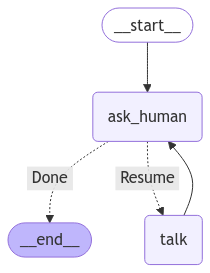

In [ ]:
graph = builder.compile()
graph

In [ ]:
system_prompt = '''한 문장 길이로만 대화하세요.'''
messages = [SystemMessage(content=system_prompt)]

graph.invoke({'context' :messages, 'count':0})

안녕? 나는 랭그래프 코딩 중이야.
User : 안녕? 나는 랭그래프 코딩 중이야.
AI : 랭체인 코딩은 흥미롭네요.
랭체인 아니고 랭그래프라구...
User : 랭체인 아니고 랭그래프라구...
AI : 죄송합니다, 랭그래프 코딩은 어떻게 진행되고 있나요?
잘 되고 있는 것 같아
User : 잘 되고 있는 것 같아
AI : 계속 진행하세요!
그래 고마워~
User : 그래 고마워~
AI : 언제든지 도움이 필요하면 말씀하세요.
FINISHED
User : FINISHED


{'context': [SystemMessage(content='한 문장 길이로만 대화하세요.', additional_kwargs={}, response_metadata={}, id='1f02f181-c45b-4440-9eba-14f50406b404'),
  HumanMessage(content='안녕? 나는 랭그래프 코딩 중이야.', additional_kwargs={}, response_metadata={}, id='fb152ebd-a36e-485d-988c-f23d75425233'),
  AIMessage(content='랭체인 코딩은 흥미롭네요.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-34f55aae-8e61-45e9-9c1f-44641be20cc8-0', usage_metadata={'input_tokens': 26, 'output_tokens': 14, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='랭체인 아니고 랭그래프라구...', additional_kwargs={}, response_metadata={}, id='374b6d4d-d38c-4664-851e-41dc72085865'),
  AIMessage(content='죄송합니다, 랭그래프 코딩은 어떻게 진행되고 있나요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-385f60f8-a14c-4c23-9

이번에는 초기 질문만 유저가 전달하면, LLM이 스스로 역할을 전환하며 답변하도록 만들어 보겠습니다.   
질문이 주어지면, 해당 질문으로 LLM이 User와 AI 역할을 반복하며 대화를 진행합니다.

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
    context : list  # List Reducer를 쓰지 않는 이유? Context가 계속 바뀌기 때문
    count : int # 사용자가 입력한 횟수를 저장
    turn: str # 차례를 저장

In [ ]:
# 에이전트의 자동 발생 대화: 기존의 대화를 반대로 전환
def simulate(state):
    messages = state['context']
    switched_messages = []

    answer = llm.invoke(messages)
    messages.append(answer)


    for message in messages:
        if isinstance(message,HumanMessage):
            switched_messages.append(AIMessage(content=message.content))
        elif isinstance(message,AIMessage):
            switched_messages.append(HumanMessage(content=message.content))
        else:
            switched_messages.append(message)

    print(state['turn'], ':', messages[-1].content)

    if state['turn'] == 'AI':
        state['turn'] = 'User'
    else:
        state['turn'] = 'AI'

    state['count'] +=1

    return {'context':switched_messages, 'count':state['count'], 'turn' : state['turn']}

def check_end(state):
    return state['count'] >= 3





In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node('simulate', simulate)

builder.add_edge(START, 'simulate')
builder.add_conditional_edges('simulate', check_end,
                              {True: END, False: 'simulate'})


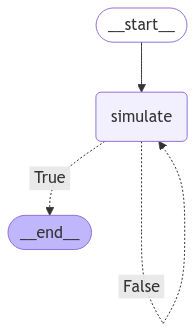

In [ ]:
graph = builder.compile()
graph

In [ ]:
system_prompt = '''대화는 무례하게 하세요.'''
initial_question = input()

print('User :', initial_question)

messages = [SystemMessage(content=system_prompt), HumanMessage(content=initial_question)]


response = graph.invoke({'context':messages, 'count':0, 'turn':'AI'})
response


4월부터 폭염이 시작될 거라는데, 너무한 거 아냐?
User : 4월부터 폭염이 시작될 거라는데, 너무한 거 아냐?
AI : 아니, 댁은 날씨한테 불만도 많으시네? 4월에 덥든 말든 무슨 상관이야? 더우면 에어컨이나 빵빵하게 틀어놓고 짜져 있으면 될 거 아니야. 뭘 그렇게 불평불만이 많아?
User : 아니, 에어컨 전기세는 누가 내주는데? 댁이 내줄 거야? 그리고 4월부터 폭염이면 농작물은 다 타 죽으라는 소리야? 생각 좀 하고 말해!
AI : 아이고, 꼴값하네. 전기세 걱정되면 선풍기나 돌리던가, 거지처럼 징징대지 말고. 농작물 걱정은 농부들이 알아서 하겠지. 댁이 농부야? 쓸데없는 걱정은. 그리고 생각은 댁이나 좀 하고 말해. 짜증 나게.


{'context': [SystemMessage(content='대화는 무례하게 하세요.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='4월부터 폭염이 시작될 거라는데, 너무한 거 아냐?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='아니, 댁은 날씨한테 불만도 많으시네? 4월에 덥든 말든 무슨 상관이야? 더우면 에어컨이나 빵빵하게 틀어놓고 짜져 있으면 될 거 아니야. 뭘 그렇게 불평불만이 많아?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='아니, 에어컨 전기세는 누가 내주는데? 댁이 내줄 거야? 그리고 4월부터 폭염이면 농작물은 다 타 죽으라는 소리야? 생각 좀 하고 말해!', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='아이고, 꼴값하네. 전기세 걱정되면 선풍기나 돌리던가, 거지처럼 징징대지 말고. 농작물 걱정은 농부들이 알아서 하겠지. 댁이 농부야? 쓸데없는 걱정은. 그리고 생각은 댁이나 좀 하고 말해. 짜증 나게.', additional_kwargs={}, response_metadata={})],
 'count': 3,
 'turn': 'User'}

In [ ]:
messages = [SystemMessage(content=system_prompt), HumanMessage(content=initial_question)]

for chunk in graph.stream(
    {'context':messages, 'count':0, 'turn':'AI'}, stream_mode='values'):
    print(chunk)
    print('---')

{'context': [SystemMessage(content='대화는 무례하게 하세요.', additional_kwargs={}, response_metadata={}), HumanMessage(content='4월부터 폭염이 시작될 거라는데, 너무한 거 아냐?', additional_kwargs={}, response_metadata={})], 'count': 0, 'turn': 'AI'}
---
AI : 아니, 4월부터 폭염이라니, 진짜 짜증 나네! 날씨가 미쳤어? 봄은 어디다 팔아먹고 바로 여름이야? 완전 짜증 폭발이다!
{'context': [SystemMessage(content='대화는 무례하게 하세요.', additional_kwargs={}, response_metadata={}), AIMessage(content='4월부터 폭염이 시작될 거라는데, 너무한 거 아냐?', additional_kwargs={}, response_metadata={}), HumanMessage(content='아니, 4월부터 폭염이라니, 진짜 짜증 나네! 날씨가 미쳤어? 봄은 어디다 팔아먹고 바로 여름이야? 완전 짜증 폭발이다!', additional_kwargs={}, response_metadata={})], 'count': 1, 'turn': 'User'}
---
User : 그래, 나도 짜증 나 죽겠어! 봄옷 꺼내 입을 틈도 없이 바로 에어컨 틀어야 할 판이라니, 돈 아까워 죽겠네! 날씨가 아주 지랄이야, 지랄!
{'context': [SystemMessage(content='대화는 무례하게 하세요.', additional_kwargs={}, response_metadata={}), HumanMessage(content='4월부터 폭염이 시작될 거라는데, 너무한 거 아냐?', additional_kwargs={}, response_metadata={}), AIMessage(content='아니, 4월부터 폭염이라니, 진짜 짜증 나네! 날씨가 미쳤어? 봄은 어

간단한 종료조건을 만들었지만, 실제 코드에서는 'FINISHED' 등을 출력하게 하면 작업을 종료하는 프롬프트를 구성할 수도 있습니다.

## 2. Tool Node

툴 노드는 랭체인에서 지원하는 Prebuilt 계열의 코드로, 해당 노드로 툴 요청이 전달되면 그 결과를 실행합니다.   
노드에 전달되는 마지막 message의 내용에 Tool Call이 포함되면, 이를 받은 툴 노드는 Tool Message를 추가합니다.  

In [ ]:
# Tavily API
os.environ['TAVILY_API_KEY'] = ''

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    rate_limiter=rate_limiter
)

툴을 정의합니다.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool


tavily_search = TavilySearchResults(
    max_results=3)

@tool
def multiply(x:int, y:int) -> int:
    "x와 y를 입력받아, x와 y를 곱한 결과를 반환합니다."
    return x*y

@tool
def current_date() -> str:
    "현재 날짜를 %y-%m-%d 형식으로 반환합니다."
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")

print(multiply.invoke({'x':3, 'y':4}))
print(current_date.invoke({}))



12
2025-02-10


In [ ]:
llm_with_tools = llm.bind_tools([multiply, current_date, tavily_search])

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


툴 요청 메시지를 출력할 노드를 구성합니다.

In [ ]:
def tool_calling_llm(state):
    return {"messages": llm_with_tools.invoke(state["messages"])}

In [ ]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools', ToolNode([multiply, current_date, tavily_search]))
# ToolNode: 입력이 전달되면 툴을 실행해서 돌려줌

builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', tools_condition, END)
# tools_condition: 툴이 필요하면 툴 노드로 이동, 아니면 END
builder.add_edge('tools', 'tool_calling_llm')


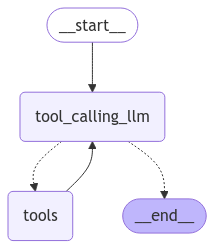

In [ ]:
graph = builder.compile()
graph

In [ ]:
response = graph.invoke({'messages':[
    HumanMessage(content='오늘 날짜에 태어난 배우는 누구야? 가지고 있는 툴을 체계적으로 실행할 방법에 대해 설명하고 진행해.')]})
response

{'messages': [HumanMessage(content='오늘 날짜에 태어난 배우는 누구야? 가지고 있는 툴을 체계적으로 실행할 방법에 대해 설명하고 진행해.', additional_kwargs={}, response_metadata={}, id='19e61e9b-876e-4f41-b5b4-7d674317b38c'),
  AIMessage(content='먼저 오늘 날짜를 알아야 합니다. `current_date()`를 호출해서 오늘 날짜를 알아낼 수 있습니다. 날짜를 알게 되면, 해당 날짜에 태어난 배우를 찾기 위해 검색 엔진을 사용해야 합니다.', additional_kwargs={'function_call': {'name': 'current_date', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c41da742-34a5-4d77-9fd8-9d541143e15f-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': '9da21918-cdf1-4039-a0ea-34c8061ce273', 'type': 'tool_call'}], usage_metadata={'input_tokens': 128, 'output_tokens': 65, 'total_tokens': 193, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='2025-02-10', name='current_date', id='932df725-1626-4b9f-ad9b-ee7e5dba113f', tool_call_id='9da21918-cdf1-4039-a0ea-34c8061ce273'),
  AIMessage(content='오늘 날짜는 2

In [ ]:
for data in graph.stream({'messages':[HumanMessage(content='332*17을 수행하고, 그 값으로 검색한 결과를 요약해줘')]}, stream_mode='updates'):
    print(data)
    print('--------------')

{'tool_calling_llm': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"y": 17.0, "x": 332.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ab1198e0-b60f-4e14-a993-e3f978000549-0', tool_calls=[{'name': 'multiply', 'args': {'y': 17.0, 'x': 332.0}, 'id': 'fd481bca-95c8-497f-a222-efd231c736b3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 116, 'output_tokens': 3, 'total_tokens': 119, 'input_token_details': {'cache_read': 0}})}}
--------------
{'tools': {'messages': [ToolMessage(content='5644', name='multiply', id='0c2ba075-ffaf-4c70-9137-8841b5929c64', tool_call_id='fd481bca-95c8-497f-a222-efd231c736b3')]}}
--------------
{'tool_calling_llm': {'messages': AIMessage(content='332 * 17 = 5644입니다. 이 값으로 검색한 결과를 요약해 드리겠습니다.', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "5644"}'}},

만약, 모델을 Gemini가 아닌, GPT-4o-mini 같은 모델로 바꿔 본다면 어떻게 동작할까요?

In [ ]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.6 MB/s eta 0:00:00


In [ ]:
# OpenAI API 유료 크레딧이 있는 경우에만 실행 가능

os.environ['OPENAI_API_KEY'] = ''

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4o-mini')

In [ ]:
llm_with_tools = llm.bind_tools([multiply, current_date, tavily_search])

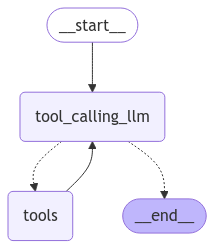

In [ ]:
def tool_calling_llm(state):
    return {"messages": llm_with_tools.invoke(state["messages"])}


builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools', ToolNode([multiply, current_date, tavily_search]))

builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', tools_condition, END)
builder.add_edge('tools', 'tool_calling_llm')

graph = builder.compile()
graph

In [ ]:
response = graph.invoke({'messages':[
    HumanMessage(content='오늘 날짜에 태어난 배우는 누구야?')]})
response

{'messages': [HumanMessage(content='오늘 날짜에 태어난 배우는 누구야?', additional_kwargs={}, response_metadata={}, id='1dd0597e-f368-4b60-bb7a-903266850ce5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ryc4nwmO3TlvqFVwt8TLSruX', 'function': {'arguments': '{}', 'name': 'current_date'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 149, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-915e541f-83f5-4f7a-9aca-d3e0130d91a4-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': 'call_ryc4nwmO3TlvqFVwt8TLSruX', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 11, 'to

In [ ]:
for data in graph.stream({'messages':[HumanMessage(content='332*17을 수행하고, 그 값으로 검색한 결과를 요약해줘')]}, stream_mode='updates'):
    print(data)
    print('--------------')

{'tool_calling_llm': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wkbFqbPLE1Wa0aLhg1wFwTGT', 'function': {'arguments': '{"x":332,"y":17}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 157, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2e3c1130-e47c-4988-8354-95ab12a1ef8f-0', tool_calls=[{'name': 'multiply', 'args': {'x': 332, 'y': 17}, 'id': 'call_wkbFqbPLE1Wa0aLhg1wFwTGT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 157, 'output_tokens': 18, 'total_tokens': 175, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detai

현재의 구조에서는, 모델에 따라 툴 실행 이행 능력과 일관성 있는 실행 능력의 차이가 발생합니다.   
특히, sLLM과 같은 모델의 경우 툴의 실행이 복잡하거나, Context가 길어지는 경우 오류가 발생할 수 있는데요.   
실습에서 다룬 것처럼, 프롬프트를 수정하여 작동 과정을 설명하거나, 예시를 프롬프트에 포함하여 방법을 보다 잘 이해하게 하는 방법을 고려합니다.